## Import

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from tqdm import tqdm

In [11]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

## Initialization

In [5]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

device(type='cpu')

## Constant

In [33]:
DATA_ROOT = "../data/"
WORKERS = 2

BATCH_SIZE = 64
IMAGE_SIZE = 64


z_dim = 256
img_channels = 3
features_dim = 64

num_epochs = 10
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999

criterion = nn.BCEWithLogitsLoss()

## Setup

In [8]:
my_transforms = transforms.Compose([
   transforms.Resize(IMAGE_SIZE),
   transforms.CenterCrop(IMAGE_SIZE),
   transforms.ToTensor(),
   transforms.Normalize(
       [0.5 for _ in range(img_channels)], [0.5 for _ in range(img_channels)]
   ),
])

## Load Dataset

In [23]:
dataset = dset.ImageFolder(root=DATA_ROOT, transform=my_transforms)

In [25]:
dataloader = torch.utils.data.DataLoader(
    dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=WORKERS
)

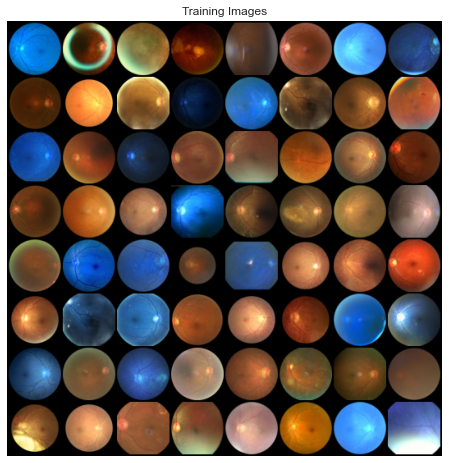

In [27]:
import torchvision.utils as vutils

real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

## Helper Function

In [39]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

## Descriminator

In [9]:
class Discriminator(nn.Module):
    """
    DCGAN Discriminator
    """
    
    def __init__(self, features_dim=64, img_channels=3, kernel_size=4, stride=2, padding=1):
        
        super(Discriminator, self).__init__()
        
        self.net = nn.Sequential(
            # img_channels x 64 x 64
            nn.Conv2d(img_channels, features_dim, kernel_size, stride, padding),
            nn.LeakyReLU(0.2, inplace=True),
            
            # features_dim x 32 x 32
            nn.Conv2d(features_dim, features_dim * 2, kernel_size, stride, padding),
            nn.BatchNorm2d(features_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (features_dim * 2) x 16 x 16
            nn.Conv2d(features_dim * 2, features_dim * 4, kernel_size, stride, padding),
            nn.BatchNorm2d(features_dim * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (features_dim * 4) x 8 x 8
            nn.Conv2d(features_dim * 4, features_dim * 8, kernel_size, stride, padding),
            nn.BatchNorm2d(features_dim * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # (features_dim * 8) x 4 x 4
            nn.Conv2d(features_dim * 8, 1, kernel_size, stride, padding),
            # 1 x 1 x 1
            nn.Sigmoid()
        )
        
    def forward(self, image):
        return self.net(image)

## Generator

In [29]:
class Generator(nn.Module):
    """
    DCGAN Generator
    """
    
    def __init__(self, z_dim, features_dim=64, img_channels=3, kernel_size=4, stride=2, padding=1):
        
        super(Generator, self).__init__()
        
        self.net = nn.Sequential(
            # z_dim x 1 x 1
            nn.ConvTranspose2d(z_dim, features_dim * 16, kernel_size, stride=1, padding=0),
            nn.BatchNorm2d(features_dim * 16),
            nn.ReLU(inplace=True),
            
            # (features_dim * 16) x 4 x 4
            nn.ConvTranspose2d(features_dim * 16, features_dim * 8, kernel_size, stride, padding),
            nn.BatchNorm2d(features_dim * 8),
            nn.ReLU(inplace=True),
            
            # (features_dim * 8) x 8 x 8
            nn.ConvTranspose2d(features_dim * 8, features_dim * 4, kernel_size, stride, padding),
            nn.BatchNorm2d(features_dim * 4),
            nn.ReLU(inplace=True),
            
            # (features_dim * 4) x 16 x 16
            nn.ConvTranspose2d(features_dim * 4, features_dim * 2, kernel_size, stride, padding),
            nn.BatchNorm2d(features_dim * 2),
            nn.ReLU(inplace=True),
            
            # (features_dim * 2) x 32 x 32
            nn.ConvTranspose2d(features_dim * 2, img_channels, kernel_size, stride, padding),
            # img_channels x 64 x 64
            nn.Tanh()
        )
        
    def forward(self, image):
        return self.net(image)

## Model Building

In [30]:
netD = Discriminator(features_dim, img_channels).to(device)
netG = Generator(z_dim, features_dim, img_channels).to(device)

In [36]:
# custom weights initialization called on netG and netD
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
        
netG.apply(weights_init)
netD.apply(weights_init)
pass

In [ ]:
# Setup Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta_1, beta_2))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta_1, beta_2))

## Traning

In [38]:
real_label = 1
fake_label = 0

In [41]:
get_noise(BATCH_SIZE, z_dim, device=device)

torch.Size([64, 256])

In [57]:
D_losses = []
G_losses = []

for epoch in range(num_epochs):
    for real, _ in tqdm(dataloader):
        
        real = real.to(device)
        noise = torch.randn(64, z_dim, 1, 1, device=device)
        fake = netG(noise)
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
 
        optimizerD.zero_grad()
        
        disc_fake_pred = netD(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        
        disc_real_pred = netD(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        optimizerD.step()
        
        D_losses.append(disc_loss.item())
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        
        optimizerG.zero_grad()
        
        noise = torch.randn(64, z_dim, 1, 1, device=device)
        fake = netG(noise)
        disc_fake_pred = netD(fake)
        
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        
        # Update gradients
        gen_loss.backward()
        # Update optimizer
        optimizerG.step()
        
        G_losses.append(gen_loss.item())
        

  3%|███▉                                                                                                                                         | 9/325 [00:57<31:30,  5.98s/it]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x10475c5e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/local/Cellar/python@3.9/3.9.6/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/usr/local/Cellar/python@3.9/3.9.6/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/usr/local/Cellar/python@3

KeyboardInterrupt: 

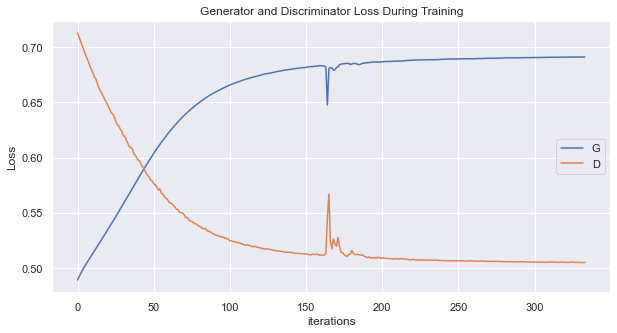

In [58]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

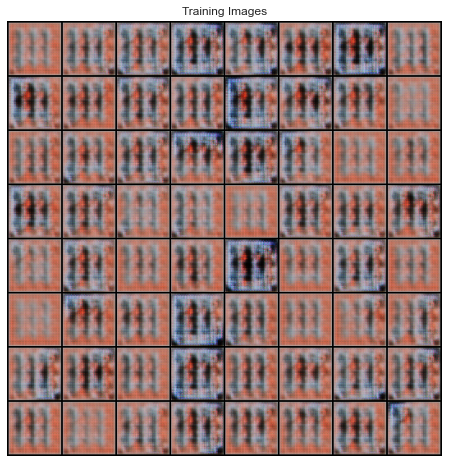

In [62]:
import torchvision.utils as vutils

with torch.no_grad():
    fake = netG(noise).detach().cpu()
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True).cpu()))